In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt

import src.crs as crs

# 한글출력
matplotlib.rc('font', family='AppleGothic')  # MacOS
# matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

# Reco Process

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data-preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

# 3. bill calc
min_per = 10
max_per = 80

bc_result = crs.utils.bill_calc(m, p, min_per, max_per)

# 4. normal analysis
n_result = crs.utils.normal_analysis(bc_result)

# 5. mean analysis
m_result = crs.utils.mean_analysis(m, p, min_per, max_per)

# 6. similarity analysis
s_result = crs.utils.similarity_analysis(m, p, min_per, max_per)

/Users/formegusto/Desktop/idoformegusto/development/research/distribution-by-contribution/src/crs/utils/data_preprocessing.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  datas_df[household_name] = household_df[col][3:].to_list()
/Users/formegusto/Desktop/idoformegusto/development/research/distribution-by-contribution/src/crs/utils/data_preprocessing.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  month_usage_df[name] = [


# 세대부, 공용부, APT (아파트 전체 사용량 혹은 사용요금)
- 2020.01 데이터를 기준으로, 한전 계산기도 2020.01 방식으로 계산이 들어간다.

In [4]:
households_cnt = len(m.iloc[0][1:])
public_percentage = 30

df_1 = pd.DataFrame(columns=["세대부 ({} 가구)".format(households_cnt), 
                             "공용부 ({}%)".format(public_percentage),
                            "APT"])

# 사용량
households_kwh = m.iloc[0][1:].sum()
APT = round((households_kwh * 100) / (100 - public_percentage))
public_kwh = APT - households_kwh

# 최종청구금액
APT_bill = int(bc_result['bill']['single'][str(public_percentage)][1])
public_bill = int(bc_result['public_bill']['single'][str(public_percentage)][1])
households_bill = APT_bill - public_bill

df_1.loc['사용량'] = [
    "{}kWh".format(format(households_kwh,",")), 
    "{}kWh".format(format(public_kwh,",")), 
    "{}kWh".format(format(APT,","))]
df_1.loc['요금'] = [
    "{}원".format(format(households_bill,",")), 
    "{}원".format(format(public_bill,",")), 
    "{}원".format(format(APT_bill,","))]
df_1

,세대부 (108 가구),공용부 (30%),APT
사용량,"31,104kWh","13,330kWh","44,434kWh"
요금,"3,798,980원","2,640,560원","6,439,540원"


#### 사용량은 가구 수로 나누고, 계산으로 산출되는 요금들은 가구 수로 곱해져서 산정되는 형태

In [5]:
# 1. APT (아파트 전체 사용량) 에서 요금 산정에 쓰일 
#    요금 산정 사용량을 가구 수(108)를 나누어 구한다. (4사 5입)
calc_APT = round(APT / households_cnt)
print("요금산정사용량 (4사 5입) = {}kWh".format(calc_APT))

# 2. 요금산정사용량(calc_APT)을 주택용 고압 요금표에 맞추어 전기요금계를 계산하게 된다.
#  - 해당 과정에서 산정되는 기본요금, 전력량요금, 기후환경요금, 연료비조정요금은
#    모두 가구 수(108)가 곱해진 가격으로 계산된다. 
df_2 = pd.DataFrame(columns=['기본요금', '전력량요금', '기후환경요금', '연료비조정요금', '전기요금계'])

# 기본요금, 전력량요금, 기후환경요금, 연료비조정요금 계산
in_df = []
mgmt_office = bc_result['mgmt_list']['single'][0][public_percentage - min_per]
apart = mgmt_office.apart
in_df.append(apart.basic), in_df.append(apart.elec_rate), in_df.append(apart.env), in_df.append(apart.fuel)
in_df.append(
    (apart.basic) \
    + (apart.elec_rate) \
    + (apart.env) \
    - (apart.fuel)
)

df_2.loc['단일계약요금표 산정액'] = ["{}원".format(format(_,",")) for _ in in_df]
df_2.loc['가구 수 적용'] = ["{}원".format(format(_,",")) for _ in np.array(in_df) * households_cnt]
df_2.loc['부가가치세, 전력산업기반기금 적용'] = ['-','-','-','-','-']
df_2['최종청구금액'] = ['-', '-', "{}원".format(format(mgmt_office.bill, ","))]
df_2

요금산정사용량 (4사 5입) = 411kWh


,기본요금,전력량요금,기후환경요금,연료비조정요금,전기요금계,최종청구금액
단일계약요금표 산정액,"6,060원","45,436원","2,178원","1,233원","52,441원",-
가구 수 적용,"654,480원","4,907,088원","235,224원","133,164원","5,663,628원",-
"부가가치세, 전력산업기반기금 적용",-,-,-,-,-,"6,439,540원"


#### 산정된 아파트 전체 요금에서 수거되는 세대부 요금
- 각 가구들은 자신이 사용한 만큼은 산정된 아파트 전체 요금에서 수거해간다. 그리고 이 나머지로 만들어지는 것이 공용부의 요금이다.
- 해당 표는 직관적으로 나타내기 위한 표로, 실제 가구별 요금 산정 시 원 미만 절사, 4사 5입 등의 계산이 추가적으로 들어가기 때문에 위와 같이 나타내면 실제 합산 요금과는 다르게 나타나기 때문에 합산요금은 포함하지 않았다.

In [6]:
df_3 = pd.DataFrame(index=["기본요금", "전력량요금", "기후환경요금", 
                           "연료비조정요금"])
df_3['APT'] = df_2.iloc[1].values[:4]

# 세대부 수거액
households = bc_result['mgmt_list']['single'][0][20].households
basic = np.array([_.basic for _ in households])
elec_rate = np.array([_.elec_rate for _ in households])
env = np.array([_.env for _ in households])
fuel = np.array([_.fuel for _ in households])
households_total = np.array([basic.sum(), elec_rate.sum(), env.sum(), fuel.sum()])

df_3['세대부'] = ["{}원".format(format(_,",")) for _ in households_total]

# 공용부 수거액
public_total = (np.array(in_df[:4]) * households_cnt) - households_total
df_3['공용부'] = ["{}원".format(format(_,",")) for _ in public_total]

df_3

,APT,세대부,공용부
기본요금,"654,480원","197,480원","457,000원"
전력량요금,"4,907,088원","3,118,820원","1,788,268원"
기후환경요금,"235,224원","164,805원","70,419원"
연료비조정요금,"133,164원","93,312원","39,852원"


#### “APT - 세대부”로 산정되는 공용부 요금의 특징 ( 부제 : 임의 공용부 계산 )

1. 요금 산정 사용량에서의 세대부 공용부 별 사용량 구분
- 각 가구들이 자신이 사용한 만큼은 아파트 전체 요금에서 수거해간다라고 생각을 해봤을 때, 사용량 면에서 봤을 때, 공용부는 위의 표와 같이 세대부가 전부 수거해 간 사용량 이후의 누진세 영향이 받아진 요금을 나타낼 것 이라고 예측을 해봤다.

In [7]:
households_percentage = 100 - public_percentage

calc_households = round(calc_APT * (households_percentage / 100))
calc_public = round(calc_APT * (public_percentage / 100))

df_4 = pd.DataFrame(index=["사용량", "누진세 1단계", "누진세 2단계", "누진세 3단계"])

# APT parsing
APT_nugin = [calc_APT]
_calc_APT = calc_APT

step = 0
while _calc_APT > 0:
    if (step == 2) or (_calc_APT < 200):
        APT_nugin.append(_calc_APT)
        break
    else:
        _calc_APT -= 200
        step += 1
        APT_nugin.append(200)

df_4['APT'] = ["{}kWh".format(_) for _ in APT_nugin]

# 세대부
households_nugin = [calc_households]
_calc_households = calc_households
step = 0
while _calc_households > 0:
    if (step == 2) or (_calc_households < 200):
        households_nugin.append(_calc_households)
        if step < 2:
            for _ in range(step, 2):
                households_nugin.append("-")
        break
    else:
        _calc_households -= 200
        step += 1
        households_nugin.append(200)
        
df_4['세대부 ({}%)'.format(households_percentage)] = \
    [_ if _ == "-" else "{}kWh".format(_) for _ in households_nugin]

# 공용부
public_nugin = [calc_public]
_calc_public = calc_public
step = 0
for _step,_ in enumerate(households_nugin[1:]):
    if _ == "-":
        step = _step
        break
    else:
        if _ == 200:
            public_nugin.append("-")
        else:
            err = 200 - _
            err = calc_public if err > _calc_public else err
            public_nugin.append(
                err
            )
            _calc_public -= err
if _calc_public > 0:
    while _calc_public > 0:
        if (step == 2) or (_calc_public < 200):
            public_nugin.append(_calc_public)
            break
        else:
            _calc_public -= 200
            step += 1
            public_nugin.append(200)
    
df_4['공용부 ({}%)'.format(public_percentage)] = \
    [_ if _ == "-" else "{}kWh".format(_) for _ in public_nugin]
df_4

,APT,세대부 (70%),공용부 (30%)
사용량,411kWh,288kWh,123kWh
누진세 1단계,200kWh,200kWh,-
누진세 2단계,200kWh,88kWh,112kWh
누진세 3단계,11kWh,-,11kWh


2. 기본요금, 전력량요금 계산
- 누진세 단계에 직접적으로 영향을 받는 요금인 기본요금과 전력량요금을 해당 실험의 대상으로 정했다.

#### 기본요금
- 일반적으로 특정 누진세에 대한 가격만 들어가는 기본요금이지만, 단일계약은 “특정 누진세 단계 X 가구 수”의 계산으로 아파트 전체요금이 정해지기 때문에, 해당 실험의 기본요금 산정은 APT 요금 산정 사용량 411kWh 중에서 공용부 사용량으로 예측되는 123kWh 중 누진세 2단계를 차지하는 구간만큼에 2단계 가격을 적용하고, 누진세 3단계를 차지하는 구간만큼에는 3단계 가격을 적용시키는 방법을 사용했다.

In [8]:
public_basic = 0
nugin_basic = [730, 1260, 6060]
start_step = 0
for idx,_ in enumerate(public_nugin[1:]):
    if _ != "-":
        start_step = idx
        break
        
for idx,p in enumerate(public_nugin[1 + start_step:]):
    rate = round(round(p / calc_public * 100) / 100 * households_cnt)
    public_basic += nugin_basic[start_step + idx] * rate
    
print("기본요금 : {}원".format(format(public_basic, ",")))

기본요금 : 184,080원


#### 전력량요금

In [9]:
public_elec = 0
nugin_elec = [73.3, 142.3, 210.6]

for idx,p in enumerate(public_nugin[1 + start_step:]):
    _elec = mt.floor(p * nugin_elec[start_step + idx])
    public_elec += _elec
public_elec *= households_cnt

df_5 = pd.DataFrame(index=['기본요금', '전력량요금'])
og_public = df_3['공용부'][:2].values
tmp_public_total = np.array([public_basic, public_elec])
tmp_public = ["{}원".format(format(_,",")) for _ in tmp_public_total]

df_5['실제 공용부 요금'] = og_public
df_5['임의 공용부 요금'] = tmp_public
df_5.loc['합계'] = [
    "{}원".format(format(public_total[:2].sum(), ",")),
    "{}원 (오차: {}원)".format(
        format(tmp_public_total[:2].sum(), ","),
        format(tmp_public_total[:2].sum() - public_total[:2].sum(), ",")
    )
]

df_5

,실제 공용부 요금,임의 공용부 요금
기본요금,"457,000원","184,080원"
전력량요금,"1,788,268원","1,971,324원"
합계,"2,245,268원","2,155,404원 (오차: -89,864원)"


- 세부적인 요금으로 봤을 때는 전혀다른 가격대를 보여줬지만, 이들의 합계를 봤을 때, “누진세 2단계부터 계산을 시작한 임의 공용부 요금+@” 의 결과를 보여줬다.
- **공용부의 요금은 아파트 전체 사용량 면에서 세대부 사용량 이후의 누진단계가 적용된 사용량 요금이 적용된다.**

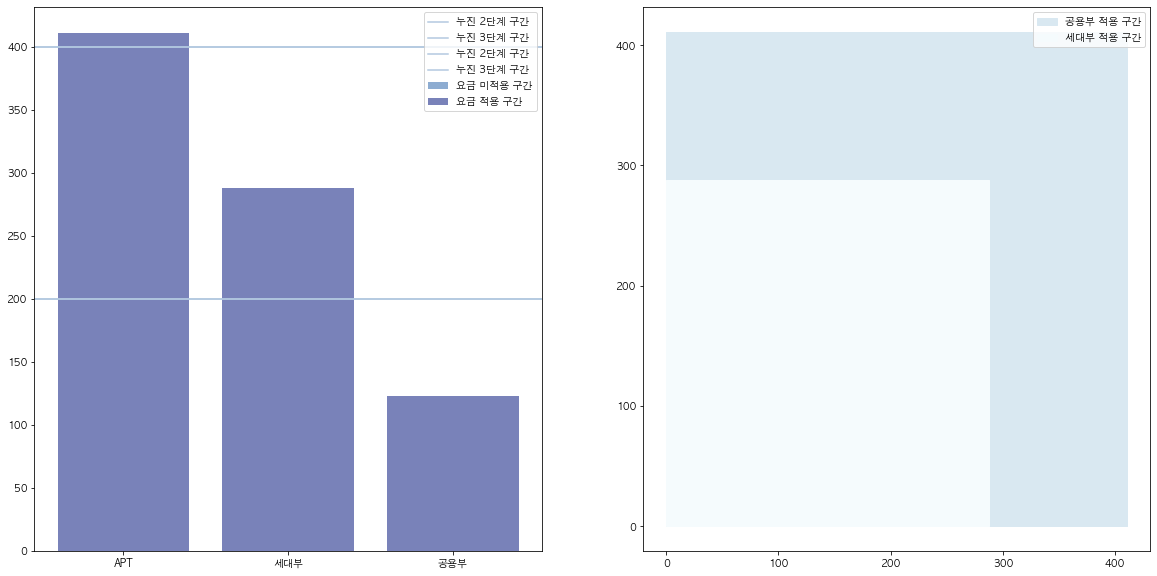

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
columns=['APT', '세대부', '공용부']
data = np.array([
    [0, calc_APT],
    [0, calc_households],
    [0, calc_public]
])

axes[0].bar(columns,data[:,0],color="#8DACD1", label="요금 미적용 구간")
axes[0].bar(columns,data[:,1],color="#7982B9", bottom=data[:,0], label="요금 적용 구간")

axes[0].axhline(y=200, label="누진 2단계 구간", color="#B2C8E0")
axes[0].axhline(y=400, label="누진 3단계 구간", color="#B2C8E0")

axes[0].axhline(y=200, label="누진 2단계 구간", color="#B2C8E0")
axes[0].axhline(y=400, label="누진 3단계 구간", color="#B2C8E0")

axes[0].legend(loc="upper right")

axes[1].fill_between(data[0], calc_APT, color="#D9E8F1", label="공용부 적용 구간")
axes[1].fill_between(data[1], calc_households, color="#F5FBFD", label="세대부 적용 구간")

axes[1].legend()

plt.show()

- 왼쪽의 그래프는 어느 구간부터 요금이 적용되는지에 대한 예시이고, 오른쪽은 누진세 단계가 증가할 수록 전기요금의 증가율이 높다는 것을 나타내기 위해 공용부와 세대부의 요금이 적용되는 구간을 면적으로 표현했다.
- 해당 실험은 세대부 사용량이 공용부 요금에 영향을 미친다는 것을 알아보기 위한 실험이었다. 시각화 자료들을 보면, 공용부는 세대부의 사용량 이후의 누진세 단계 부터 요금이 산정되고, 누진세가 적용되었기 때문에 세대부에 비해 작은 사용량일지라도 사용량에 따른 요금 증가율의 크기는 클 것 이다.
- 세대부 사용량이 공용부 요금에 영향을 미친다는 의미는 모든 가구의 사용량이 합산되어진 세대부 사용량 안에서 누군가는 적은 사용량을 보이고, 누군가는 많은 사용량을 보일 수 있는데, 이것들이 세부적으로 계산되어지지 않고, 이들이 합산된 세대부 사용량으로 공용부 요금이 결정되기 때문에 사용량이 적은 가구 집단과 사용량이 많은 가구 집단 사이에 형평성의 문제가 발생할 수 있다.
- 따라서 단일계약 상에 사용량이 적은 가구 집단과 사용량이 많은 가구 집단의 공용부 요금산정 기여도에 따른 가격분배를 통해 이들의 형평성 문제를 해결하는 것이 이번 과제의 주 목표이다.